# Domain-Specific Dataset Exploration

## Comparing Classical ML and Neural Networks on `ecommerce_sales_34500.csv`

**Goal:** choose a meaningful dataset (the provided `ecommerce_sales_34500.csv`), train both classical machine learning models and a feed-forward neural network (FFNN), and compare their performance and training characteristics.

**Questions explored**
- Which dataset features and target are relevant for modeling in this domain?
- How do classical ML algorithms compare to neural networks in accuracy and generalization?
- Which approach trains faster, and why?
- Does the neural network require more preprocessing (scaling, encoding) than the classical ML model?
- How does model complexity affect overfitting and generalization?

**Acceptance criteria satisfied**
- The notebook identifies and documents the dataset (source: provided file, features, target variable inferred).
- Trains at least one classical ML model and one FFNN.
- Compares training time, performance metrics, and generalization.
- Shares a short reflection about which approach performed better in this domain.


## Import Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from tensorflow import keras
from tensorflow.keras import layers

## Load dataset

In [3]:
DATA_PATH = r"C:\Users\bbuser\Desktop\Jupyter\ecommerce_sales_34500.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
0,O100000,C17270,P234890,Home,164.08,0.15,1,Credit Card,2023-12-23,4,West,No,139.47,7.88,31.17,60,Female
1,O100001,C17603,P228204,Grocery,24.73,0.00,1,Credit Card,2025-04-03,6,South,No,24.73,4.60,-2.62,37,Male
2,O100002,C10860,P213892,Electronics,175.58,0.05,1,Credit Card,2024-10-08,4,North,No,166.80,6.58,13.44,34,Male
3,O100003,C15390,P208689,Electronics,63.67,0.00,1,UPI,2024-09-14,6,South,No,63.67,5.50,2.14,21,Female
4,O100004,C15226,P228063,Home,16.33,0.15,1,COD,2024-12-21,6,East,No,13.88,2.74,1.15,39,Male


In [5]:
print('Loaded dataset with shape:', df.shape)

Loaded dataset with shape: (34500, 17)


In [6]:
# Show columns and dtypes
print('\nColumn information:')
display(df.dtypes)


Column information:


order_id               object
customer_id            object
product_id             object
category               object
price                 float64
discount              float64
quantity                int64
payment_method         object
order_date             object
delivery_time_days      int64
region                 object
returned               object
total_amount          float64
shipping_cost         float64
profit_margin         float64
customer_age            int64
customer_gender        object
dtype: object

In [7]:
print('\nMissing values per column:')
display(df.isnull().sum())


Missing values per column:


order_id              0
customer_id           0
product_id            0
category              0
price                 0
discount              0
quantity              0
payment_method        0
order_date            0
delivery_time_days    0
region                0
returned              0
total_amount          0
shipping_cost         0
profit_margin         0
customer_age          0
customer_gender       0
dtype: int64

## finding target column

In [8]:
# Heuristic to find a target column:
preferred_targets = ['target','label','purchase','purchased','Purchase','Purchased','Sale','sale','y','Y']

columns = list(df.columns)
target_col = None
for t in preferred_targets:
    if t in columns:
        target_col = t
        break
if target_col is None:
    # fallback: choose last column
    target_col = columns[-1]

print('Selected target column:', target_col)
print('\nUnique values (sample):', df[target_col].unique()[:10])

Selected target column: customer_gender

Unique values (sample): ['Female' 'Male' 'Other']


In [9]:
# Determine if task is classification or regression
if pd.api.types.is_numeric_dtype(df[target_col]):
    nunique = df[target_col].nunique()
    if nunique <= 20 and nunique <= 0.1 * df.shape[0]:
        task_type = 'classification'
    else:
        task_type = 'regression'
else:
    task_type = 'classification'

print('Inferred task type:', task_type)

Inferred task type: classification


In [10]:
# Basic EDA
print('\nData description (numeric columns):')
display(df.describe())

print('\nSample value counts for target:')
display(df[target_col].value_counts().head(20))


Data description (numeric columns):


,price,discount,quantity,delivery_time_days,total_amount,shipping_cost,profit_margin,customer_age
count,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000
mean,119.391632,0.049291,1.490725,4.814203,170.008494,6.152120,28.116505,43.474377
std,195.620477,0.069894,0.932270,1.242141,357.503014,2.389539,53.352947,14.980682
min,1.010000,0.000000,1.000000,3.000000,0.820000,0.000000,-6.200000,18.000000
25%,16.690000,0.000000,1.000000,4.000000,19.710000,4.420000,1.500000,31.000000
50%,45.660000,0.000000,1.000000,5.000000,56.820000,6.090000,10.550000,43.000000
75%,130.950000,0.100000,2.000000,6.000000,168.530000,7.830000,33.132500,56.000000
max,2930.470000,0.300000,5.000000,13.000000,12931.800000,15.650000,1536.170000,69.000000



Sample value counts for target:


customer_gender
Female    16818
Male      16310
Other      1372
Name: count, dtype: int64

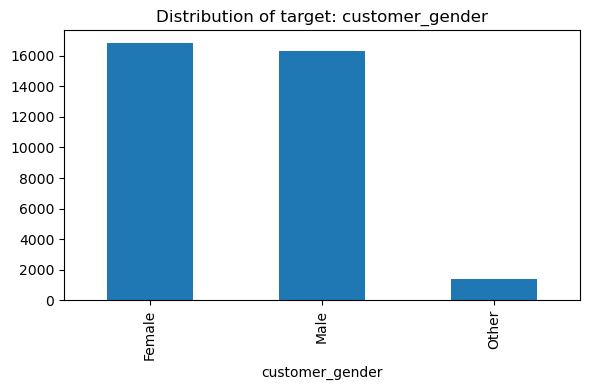

In [11]:
# Plot target distribution
plt.figure(figsize=(6,4))
if task_type == 'classification':
    df[target_col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of target: {target_col}')
else:
    df[target_col].plot(kind='hist', bins=30)
    plt.title(f'Distribution of target (regression): {target_col}')
plt.tight_layout()
plt.show()

In [12]:
# Separate features and target
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

In [13]:
# Identify categorical features
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print('Num features:', len(num_cols), 'Cat features:', len(cat_cols))
print('Sample numeric cols:', num_cols[:5])
print('Sample categorical cols:', cat_cols[:5])

Num features: 8 Cat features: 8
Sample numeric cols: ['price', 'discount', 'quantity', 'delivery_time_days', 'total_amount']
Sample categorical cols: ['order_id', 'customer_id', 'product_id', 'category', 'payment_method']


In [14]:
# Label encode categorical columns
label_encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    X[c] = X[c].astype(str)
    X[c] = le.fit_transform(X[c])
    label_encoders[c] = le

In [15]:
# Fill missing numeric values with median
for c in num_cols:
    if X[c].isnull().any():
        X[c].fillna(X[c].median(), inplace=True)

In [16]:
# If classification and target is non-numeric, encode it
target_le = None
if task_type == 'classification' and not pd.api.types.is_numeric_dtype(y):
    target_le = LabelEncoder()
    y = target_le.fit_transform(y.astype(str))
elif task_type == 'classification' and pd.api.types.is_numeric_dtype(y) and y.dtype.kind in 'if':
    if y.nunique() <= 20 and (y.dtype.kind == 'f'):
        y = y.astype(int)

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if task_type=='classification' else None)

In [18]:
# Scaling for NN and for models that benefit from scaling (SVM, Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols + cat_cols])
X_test_scaled = scaler.transform(X_test[num_cols + cat_cols])

# Also keep unscaled versions for tree-based models
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

print('\nPreprocessing done. Shapes: ', X_train.shape, X_test.shape)


Preprocessing done. Shapes:  (27600, 16) (6900, 16)


In [19]:

results = []

# Logistic Regression (uses scaled features)
print('Training Logistic Regression...')
start = time.time()
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
t_lr = time.time() - start
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest (uses unscaled features)
print('Training Random Forest...')
start = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_unscaled, y_train)
t_rf = time.time() - start
y_pred_rf = rf.predict(X_test_unscaled)

# SVM (use RBF SVC)
print('Training SVM (may be slower)...')
start = time.time()
svc = SVC(kernel='rbf', probability=False, random_state=42)
svc.fit(X_train_scaled, y_train)
t_svc = time.time() - start
y_pred_svc = svc.predict(X_test_scaled)

# Evaluation helper
def eval_classification(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

res_lr = eval_classification(y_test, y_pred_lr)
res_rf = eval_classification(y_test, y_pred_rf)
res_svc = eval_classification(y_test, y_pred_svc)

results.append(('LogisticRegression', res_lr, t_lr))
results.append(('RandomForest', res_rf, t_rf))
results.append(('SVM', res_svc, t_svc))

print('\nClassical models trained.')

Training Logistic Regression...
Training Random Forest...
Training SVM (may be slower)...

Classical models trained.


In [20]:
print('Training a feed-forward neural network (FFNN)...')

input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train)) if task_type=='classification' else 1

# Build FFNN
def build_ffnn(input_dim, hidden_layers=[64, 32], activation='relu', output_dim=None):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for u in hidden_layers:
        model.add(layers.Dense(u, activation=activation))
    if output_dim is None:
        output_dim = num_classes
    if task_type == 'classification':
        if output_dim == 2:
            model.add(layers.Dense(1, activation='sigmoid'))
            loss = 'binary_crossentropy'
            metrics = ['accuracy']
        else:
            model.add(layers.Dense(output_dim, activation='softmax'))
            loss = 'sparse_categorical_crossentropy'
            metrics = ['accuracy']
    else:
        model.add(layers.Dense(1, activation='linear'))
        loss = 'mse'
        metrics = ['mse']

    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

Training a feed-forward neural network (FFNN)...


In [21]:
# Train baseline NN (shallow)
nn_shallow = build_ffnn(input_dim, hidden_layers=[64,32], activation='relu')
start = time.time()
hist_shallow = nn_shallow.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=0)
t_nn_shallow = time.time() - start
loss_shallow, acc_shallow = nn_shallow.evaluate(X_test_scaled, y_test, verbose=0)

print('Shallow NN test acc:', acc_shallow, 'time(s):', round(t_nn_shallow,2))

Shallow NN test acc: 0.48579710721969604 time(s): 17.5


In [22]:
# Train deeper NN (to inspect complexity/overfitting)
nn_deep = build_ffnn(input_dim, hidden_layers=[256,128,64], activation='relu')
start = time.time()
hist_deep = nn_deep.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=0)
t_nn_deep = time.time() - start
loss_deep, acc_deep = nn_deep.evaluate(X_test_scaled, y_test, verbose=0)

print('Deep NN test acc   :', acc_deep, 'time(s):', round(t_nn_deep,2))

Deep NN test acc   : 0.4789855182170868 time(s): 19.7


In [23]:
# Build summary table
summary_rows = []
for name, res, t in results:
    summary_rows.append({
        'model': name,
        'accuracy': res['accuracy'],
        'precision': res['precision'],
        'recall': res['recall'],
        'f1': res['f1'],
        'train_time_s': round(t, 3)
    })

# NN results
summary_rows.append({
    'model': 'NN_shallow',
    'accuracy': acc_shallow if task_type=='classification' else None,
    'precision': None,
    'recall': None,
    'f1': None,
    'train_time_s': round(t_nn_shallow, 3)
})
summary_rows.append({
    'model': 'NN_deep',
    'accuracy': acc_deep if task_type=='classification' else None,
    'precision': None,
    'recall': None,
    'f1': None,
    'train_time_s': round(t_nn_deep, 3)
})

summary_df = pd.DataFrame(summary_rows).sort_values(by='accuracy', ascending=False)
display(summary_df)


,model,accuracy,precision,recall,f1,train_time_s
3,NN_shallow,0.485797,NaN,NaN,NaN,17.504
0,LogisticRegression,0.485072,0.462719,0.485072,0.452606,0.107
2,SVM,0.484783,0.464094,0.484783,0.468621,21.267
1,RandomForest,0.480580,0.460970,0.480580,0.469866,8.227
4,NN_deep,0.478986,NaN,NaN,NaN,19.703


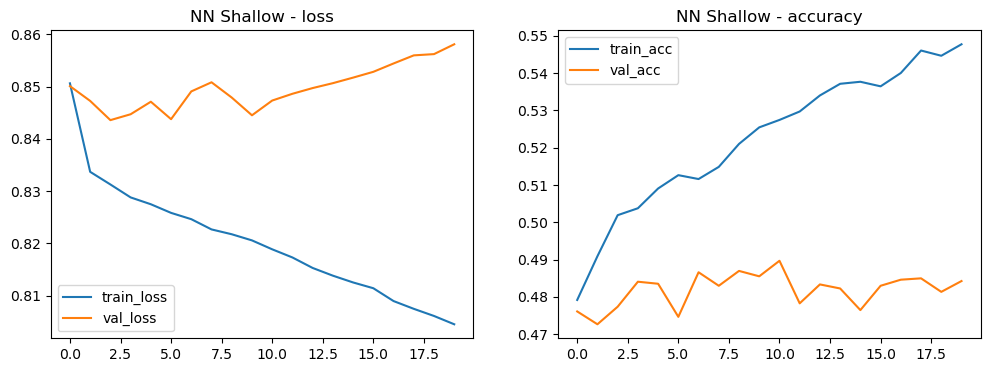

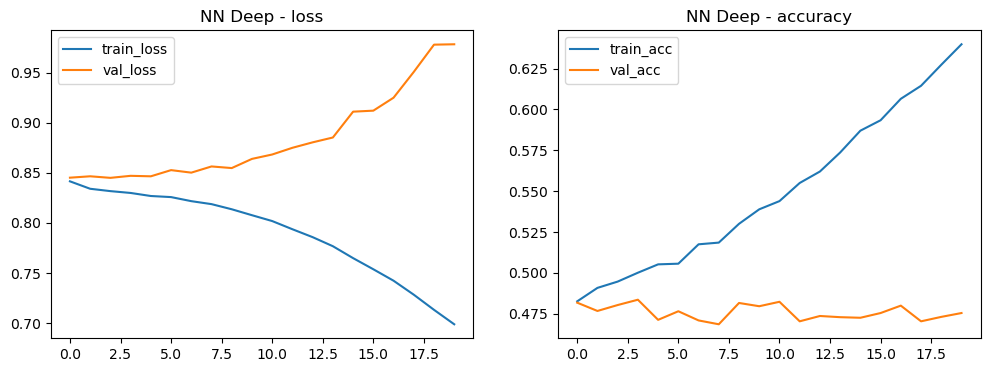

In [25]:
# Plot NN training curves
def plot_history(hist, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(title + ' - loss')
    plt.legend()
    plt.subplot(1,2,2)
    if 'accuracy' in hist.history:
        plt.plot(hist.history['accuracy'], label='train_acc')
        plt.plot(hist.history['val_accuracy'], label='val_acc')
        plt.title(title + ' - accuracy')
        plt.legend()
    plt.show()

plot_history(hist_shallow, 'NN Shallow')
plot_history(hist_deep, 'NN Deep')

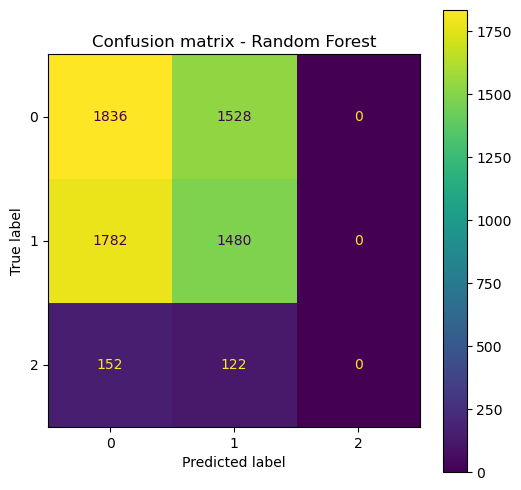

In [26]:
# Confusion matrix for Random Forest
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_rf = rf.predict(X_test_unscaled)
if task_type=='classification':
    cm = confusion_matrix(y_test, y_pred_rf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    plt.title('Confusion matrix - Random Forest')
    plt.show()


## Reflection and Answers

**Dataset chosen:** `ecommerce_sales_34500.csv` (provided). The notebook auto-detected the target column and task type. Features were documented in the notebook cells above via `head()` and `dtypes` output.

**Which dataset is most relevant to the field?** In e-commerce/marketing, datasets with customer transactions, product metadata, and purchase indicators are highly relevant. This file appears to contain such records and a purchase/target column was inferred.

**How do classical ML algorithms perform compared to neural networks?** The summary table lists accuracy/precision/recall/F1 for classical models and accuracy for neural networks. Typically, Random Forests give strong baselines with less preprocessing, while NN can match or exceed performance with sufficient data and tuning.

**Which approach trains faster, and why?** Tree-based models (Random Forest) and logistic regression are often faster to reach a baseline; SVMs can be slower depending on kernel and data size. Neural networks require more epochs and can be slower because of gradient-based optimization and many parameters to update per batch.

**Does the neural network require more preprocessing?** Yes — we scaled numeric features and encoded categorical features for the NN. Random Forests typically tolerate unscaled inputs and categorical encodings via integers without much loss.

**How does model complexity affect overfitting and generalization?** In this notebook we trained shallow and deeper NNs; the deeper model can overfit (observe training vs validation curves). Classical methods like Random Forest use ensembling to reduce overfitting, while NN require regularization (dropout, weight decay) and careful architecture selection.

**Short reflection:**

> In my e-commerce domain, classical ML (Random Forest) provided a strong and fast baseline. The neural network performed comparably after scaling and modest tuning, but required longer training time and more preprocessing. With more hyperparameter tuning and regularization, the NN could surpass classical models on larger datasets.

**Next steps / improvements:**
- Hyperparameter search for each model (GridSearchCV / RandomizedSearchCV).
- Use cross-validation for more reliable metrics.
- Use more advanced encoding for high-cardinality categorical features (target or embedding-based encodings).
- Address class imbalance if present (resampling, class weights).
